In [1]:
import numpy as np
import matlab.engine
import pandas as pd
import scipy.io as sio
from functions.functions import load_data_forGridSearch, load_object,feature_scaling_forGridSearch

from keras.models import load_model
import tensorflow as tf
import os

from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns


Using TensorFlow backend.


In [2]:
# load data
# X_train, y_train = load_data_forGridSearch("../../data", "train")
X_test, y_test = load_data_forGridSearch("../Data", "test")

In [3]:
# load matlab predictions
recalibrated_y_pred = sio.loadmat('./baseline_model/magnetic_model/CalibrateSystem_CardioMag_retrained_w_SensorGrid/recalibrated_y_pred.mat')['fieldStrength']
recalibrated_y_pred = recalibrated_y_pred[:,0:3]
assert recalibrated_y_pred.shape == y_test.shape, "Predictions for testing set do not have the same shape as the labels"
# load RF predictions
rf_y_pred = np.load("../Models/RF/GridSearch_RF_predictions.npy")
# load ANN predictions
ann_y_pred = np.load('../Models/ANN/predictions_ANN.npy')

In [4]:
data_df = pd.DataFrame(np.concatenate((X_test, y_test), axis=1),
                       columns=['x', 'y', 'z', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'Bx', 'By', 'Bz'])
data_df['Bx'] = data_df['Bx'] * 1000
data_df['By'] = data_df['By'] * 1000
data_df['Bz'] = data_df['Bz'] * 1000
data_df["B_norm"] = np.sqrt(data_df["Bx"]**2 + data_df["By"]**2 + data_df["Bz"]**2 )

data_df["baseline_Bx"] = [recalibrated_y_pred[i][0]*1000 for i in range(len(recalibrated_y_pred))]
data_df["baseline_By"] = [recalibrated_y_pred[i][1]*1000 for i in range(len(recalibrated_y_pred))]
data_df["baseline_Bz"] = [recalibrated_y_pred[i][2]*1000 for i in range(len(recalibrated_y_pred))]
data_df["baseline_B_norm"] = np.sqrt(data_df["baseline_Bx"]**2 + data_df["baseline_By"]**2 + data_df["baseline_Bz"]**2 )
data_df["e_baseline_B_norm"] = abs(data_df["baseline_B_norm"] - data_df["B_norm"])

data_df["RF_Bx"] = [rf_y_pred[i][0]*1000 for i in range(len(rf_y_pred))]
data_df["RF_By"] = [rf_y_pred[i][1]*1000 for i in range(len(rf_y_pred))]
data_df["RF_Bz"] = [rf_y_pred[i][2]*1000 for i in range(len(rf_y_pred))]
data_df["RF_B_norm"] = np.sqrt(data_df["RF_Bx"]**2 + data_df["RF_By"]**2 + data_df["RF_Bz"]**2 )
data_df["e_RF_B_norm"] = abs(data_df["RF_B_norm"] - data_df["B_norm"])

data_df["ANN_Bx"] = [ann_y_pred[i][0]*1000 for i in range(len(ann_y_pred))]
data_df["ANN_By"] = [ann_y_pred[i][1]*1000 for i in range(len(ann_y_pred))]
data_df["ANN_Bz"] = [ann_y_pred[i][2]*1000 for i in range(len(ann_y_pred))]
data_df["ANN_B_norm"] = np.sqrt(data_df["ANN_Bx"]**2 + data_df["ANN_By"]**2 + data_df["ANN_Bz"]**2 )
data_df["e_ANN_B_norm"] = abs(data_df["ANN_B_norm"] - data_df["B_norm"])



In [5]:
data_df.loc[:, 'x':'B_norm'].head()

,x,y,z,I1,I2,I3,I4,I5,I6,I7,I8,Bx,By,Bz,B_norm
0,0.051167,-0.079558,0.219436,3.503916,-4.714430,10.309934,-2.315168,10.114926,-4.730407,-17.566990,7.147020,-33.375370,4.526651,4.315893,33.956337
1,0.049293,0.072790,0.021228,-15.166091,-12.774846,-30.470276,-12.780841,10.902087,21.797058,8.277729,-10.918287,57.817382,71.497828,-35.772614,98.663413
2,-0.049424,-0.029994,0.170192,-4.588941,-1.879941,-5.360513,-3.013261,-5.403688,-8.219973,1.038851,3.413729,-21.818389,-0.740036,-9.101777,23.652317
3,-0.100103,0.020672,0.070872,26.288228,-2.343800,11.591647,0.917104,0.007322,-32.443263,-5.173050,9.272586,-58.755816,-62.097061,33.208472,91.712014
4,0.099800,0.023307,0.020556,-1.665025,18.381864,-15.295958,1.372502,-1.383196,6.429798,3.011795,13.106171,-28.518069,12.660802,-69.457825,76.144374


In [6]:
data_df.loc[:, 'baseline_Bx':'e_ANN_B_norm'].head()

,baseline_Bx,baseline_By,baseline_Bz,baseline_B_norm,e_baseline_B_norm,RF_Bx,RF_By,RF_Bz,RF_B_norm,e_RF_B_norm,ANN_Bx,ANN_By,ANN_Bz,ANN_B_norm,e_ANN_B_norm
0,-30.792192,7.359513,2.237170,31.738407,2.217931,-33.669379,4.602233,1.165511,34.002442,0.046105,-31.481385,8.146113,6.253554,33.114101,0.842236
1,38.584641,99.964263,-71.415444,128.770315,30.106903,56.833750,59.508024,-34.828724,89.355023,9.308390,59.694678,73.562436,-32.515317,100.160533,1.497120
2,-22.417416,0.379140,-9.984194,24.543195,0.890877,-20.323290,0.381795,-7.997875,21.843715,1.808602,-21.363720,0.694698,-10.015876,23.605273,0.047044
3,-75.090336,-87.688480,48.768279,125.324272,33.612258,-53.641409,-58.263826,31.780507,85.335073,6.376941,-56.031734,-63.017286,34.812450,91.228506,0.483509
4,-40.766767,11.312191,-91.045314,100.394941,24.250568,-33.386016,13.031624,-64.116752,73.453436,2.690938,-33.867240,17.086959,-71.873456,81.269600,5.125226


In [7]:
to_plot = data_df.groupby(['x', 'y', 'z'])[['e_baseline_B_norm', 'e_RF_B_norm', 'e_ANN_B_norm']].mean()
to_plot.head()

,,,e_baseline_B_norm,e_RF_B_norm,e_ANN_B_norm
x,y,z,,,
-0.101209,0.121251,0.022060,26.728451,9.201784,4.282372
-0.101123,0.120660,0.072057,26.094708,5.986069,4.085192
-0.101037,0.120068,0.122053,22.214767,5.505656,3.770827
-0.100951,0.119476,0.172050,20.182817,4.144988,3.480386
-0.100865,0.118885,0.222046,18.971062,3.262346,3.470660


In [8]:
to_plot = to_plot.reset_index()
to_plot.describe()

,x,y,z,e_baseline_B_norm,e_RF_B_norm,e_ANN_B_norm
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,0.000856,0.017335,0.120242,15.580016,3.863746,2.697679
std,0.072195,0.069542,0.071160,4.780826,1.873366,0.799130
min,-0.101209,-0.081091,0.019371,7.824957,1.662983,1.603466
25%,-0.050659,-0.029739,0.070000,11.951937,2.431673,2.116916
50%,0.000315,0.020941,0.120628,14.394236,3.268803,2.487506
75%,0.050740,0.071392,0.171337,18.388328,4.477219,3.133950
max,0.101164,0.123295,0.222046,29.483950,9.532625,5.039080


# plot as subplot

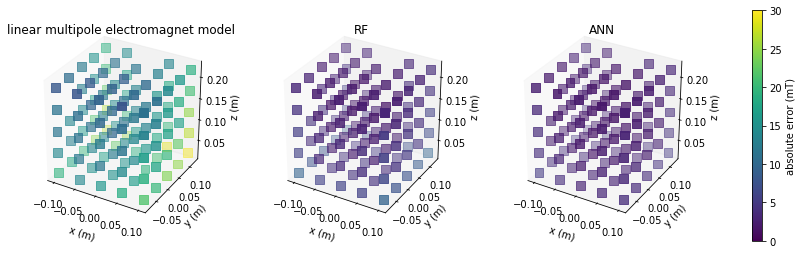

In [10]:
from matplotlib import colors



fig = plt.figure(figsize=(14, 8))

vals = np.concatenate((to_plot['e_baseline_B_norm'].values, 
                       to_plot['e_RF_B_norm'].values, 
                       to_plot['e_ANN_B_norm'].values), axis=None)
vals = np.append(vals, [0, 30])

mynorm = colors.Normalize(vmin=np.min(vals), vmax=np.max(vals))

# colmap = cm.ScalarMappable(cmap='YlGnBu')
colmap = cm.ScalarMappable(cmap='viridis')
colmap.set_array(vals)

ax1 = fig.add_subplot(131, projection='3d', aspect='equal')

ax1.scatter(to_plot['x'].values, to_plot['y'].values, to_plot['z'].values,
           marker='s',s = 80, c=to_plot['e_baseline_B_norm'].values, cmap='viridis', norm = mynorm)


ax1.grid(False)
ax1.set_xlabel('x (m)');
ax1.set_ylabel('y (m)');
ax1.set_zlabel('z (m)');
ax1.set_title("linear multipole electromagnet model")

ax2 = fig.add_subplot(132, projection='3d', aspect='equal')

# reference for cmap. note cmap and c are different!
# http://matplotlib.org/examples/color/colormaps_reference.html
ax2.scatter(to_plot['x'].values, to_plot['y'].values, to_plot['z'].values,
           marker='s',s = 80, c=to_plot['e_RF_B_norm'].values, cmap='viridis', norm = mynorm)
ax2.grid(False)
ax2.set_xlabel('x (m)');
ax2.set_ylabel('y (m)');
ax2.set_zlabel('z (m)');
ax2.set_title("RF")

ax3 = fig.add_subplot(133, projection='3d', aspect='equal')

# reference for cmap. note cmap and c are different!
# http://matplotlib.org/examples/color/colormaps_reference.html
ax3.scatter(to_plot['x'].values, to_plot['y'].values, to_plot['z'].values,
           marker='s',s = 80, c=to_plot['e_ANN_B_norm'].values, cmap='viridis', norm = mynorm)

ax3.grid(False)
ax3.set_xlabel('x (m)');
ax3.set_ylabel('y (m)');
ax3.set_zlabel('z (m)');
ax3.set_title("ANN")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(colmap, cax=cbar_ax, ax = [ax1, ax2, ax3], fraction = .1)
cbar.ax.set_ylabel('absolute error (mT)')

plt.show()

# save figure
# fig.savefig("../Figures/error_distribution.png", dpi=300)


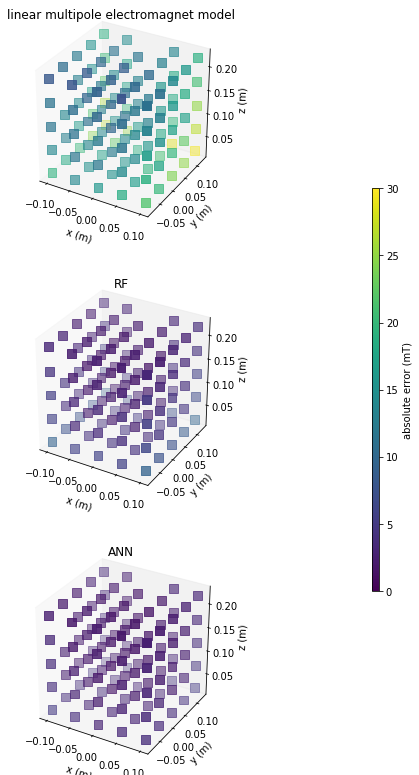

In [12]:
from matplotlib import colors


fig = plt.figure(figsize=(9, 14))

vals = np.concatenate((to_plot['e_baseline_B_norm'].values, 
                       to_plot['e_RF_B_norm'].values, 
                       to_plot['e_ANN_B_norm'].values), axis=None)
vals = np.append(vals, [0, 30])

mynorm = colors.Normalize(vmin=np.min(vals), vmax=np.max(vals))

# colmap = cm.ScalarMappable(cmap='YlGnBu')
colmap = cm.ScalarMappable(cmap='viridis')
colmap.set_array(vals)

ax1 = fig.add_subplot(311, projection='3d', aspect='equal')

ax1.scatter(to_plot['x'].values, to_plot['y'].values, to_plot['z'].values,
           marker='s',s = 80, c=to_plot['e_baseline_B_norm'].values, cmap='viridis', norm = mynorm)


ax1.grid(False)
ax1.set_xlabel('x (m)');
ax1.set_ylabel('y (m)');
ax1.set_zlabel('z (m)');
ax1.set_title("linear multipole electromagnet model")

ax2 = fig.add_subplot(312, projection='3d', aspect='equal')

# reference for cmap. note cmap and c are different!
# http://matplotlib.org/examples/color/colormaps_reference.html
ax2.scatter(to_plot['x'].values, to_plot['y'].values, to_plot['z'].values,
           marker='s',s = 80, c=to_plot['e_RF_B_norm'].values, cmap='viridis', norm = mynorm)
ax2.grid(False)
ax2.set_xlabel('x (m)');
ax2.set_ylabel('y (m)');
ax2.set_zlabel('z (m)');
ax2.set_title("RF")

ax3 = fig.add_subplot(313, projection='3d', aspect='equal')

# reference for cmap. note cmap and c are different!
# http://matplotlib.org/examples/color/colormaps_reference.html
ax3.scatter(to_plot['x'].values, to_plot['y'].values, to_plot['z'].values,
           marker='s',s = 80, c=to_plot['e_ANN_B_norm'].values, cmap='viridis', norm = mynorm)

ax3.grid(False)
ax3.set_xlabel('x (m)');
ax3.set_ylabel('y (m)');
ax3.set_zlabel('z (m)');
ax3.set_title("ANN")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(colmap, cax=cbar_ax, ax = [ax1, ax2, ax3], fraction = .1)
cbar.ax.set_ylabel('absolute error (mT)')

plt.show()

# save figure
# fig.savefig("../Figures/error_distribution_v.png", dpi=300)